<a href="https://colab.research.google.com/github/abidalrekab/DeepL/blob/master/tutorial6_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Networks
In this exercise you will:
1. Complete the design of a convolutional neural network similar to the classic LeNet from http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf .
2. Use cross-validation to determine the optimal number of filters/activation maps per layer.

This model will train best on a GPU.  Google Colab is <b>highly recommended</b>.  See our Slack #homework channel for how to enable the GPU runtime on Colab.    

Let's get started.  Note the use of PyTorch dataset samplers.  You'll want to familiarize yourself with them by reading the docs: https://pytorch.org/docs/stable/data.html.

<b>Important Note</b>:  Consider this notebook 'starter code'.  You will need to extend it, alter it, and in some cases replace it.  Please write whatever code you need to in order to correctly solve the problem!

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SequentialSampler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
import numpy as np
import matplotlib.pyplot as plt

cuda:0


Note the 2-D input_size.  We are preparing to read the MNIST dataset and resizing the images to 32x32 pixels with zero padding includes.  They are grayscale already, so the input will be 32x32x1.

In [0]:
# Hyper Parameters 
input_size = (32, 32)
num_classes = 10
num_epochs = 25
batch_size_train = 256
batch_size_val = 256
batch_size_test = 1024
learning_rate = 2e-3
num_folds = 6  # V-fold cross validation!
v = 1  # The filter hyperparameter.  The number of activation maps is dependent.
torch.set_printoptions(threshold=1000)

This initially downloads two datasets, one for training and validation (called train_dataset) and one for test.  You will eventually need to split the training data into training and validation sets.

In [0]:
# Load image data and transform images to 32x32x1
train_dataset = dsets.MNIST(root='./data',
                         train=True,
                         transform=transforms.Compose([
                             transforms.Resize(input_size),
                             transforms.ToTensor()]),
                         download=True)
test_dataset = dsets.MNIST('./data',
                        train=False,
                        transform=transforms.Compose([
                            transforms.Resize(input_size),
                            transforms.ToTensor()]),
                        download=True)

In [0]:
# Dataset loaders (handle mini-batching of data) 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=False)

Here is a CNN model architecture, missing some layers.  See the problem statement for guidance on how to complete it.

In [0]:
class LeNet5(nn.Module):
    # A version of LeNet-5.  Note the hyperparameter 'v' (n^v activation maps).
    def __init__(self, v=0):
        super(LeNet5, self).__init__()
        # 1 image input channel, 6 filters, 5x5 kernel
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 2**v, kernel_size=(5, 5)),                        # c1
            nn.ReLU(),  # relu1
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),                    # s2
            nn.Conv2d(2**v, 3**v, kernel_size=(5, 5)),                     # c3
            nn.ReLU(),  # relu3
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),                    # s4
            nn.Conv2d(3**v, 5**v, kernel_size=(5, 5),stride = 1),          # c5
            nn.ReLU()                                                    # relu5
           
        )

        self.fc = nn.Sequential(
            nn.Linear(5**v, 84),                                  #f6
            nn.ReLU(),                                                    # relu5
            nn.Linear(84, 10)                                               #f7
    
        )
        
    def forward(self, input):
        convout = self.convnet(input)
        convout = convout.view(input.size(0), -1)
        output = self.fc(convout)
        return output
        

The followign function will train the model for a single epoch and report the training loss.

In [0]:
def train_one_epoch(epoch_num):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        optimizer.zero_grad() 
        outputs = model(images) 
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()
        if (i + 1) % 10 == 0:
            print('Epoch: [% d/% d], Step: [% d/% d], Loss: %.4f'
                  % (epoch_num + 1, num_epochs, i + 1,
                     len(train_dataset) // batch_size_train, loss.item())) 

The following functions are provided for your convenience.  They compute the error and accuracy of all data supplied  via a loader.

In [0]:
def epoch_error(loader, length, split='validation'):
    """ Computes the loss for all data points in a loader.
       
        Inputs:
            loader: Pytorch data loader (object)
            length: Number of data points (integer)
            split: Name of split, typically 'train', 'test', or 'validation' (string)
        
        Returns:
            loss (floating point)
    """
    model.eval()
    # Measure the error for the entire loader split.
    i = 0
    loss = 0.
    num_batches = 0
    for images, labels in loader:  # One batch at a time!
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss += criterion(outputs, labels).item()
        # print(f'Batch loss is {criterion(outputs, labels)}')
        num_batches += 1

    print(f'Error of the model on the {length} {split} images: {loss / num_batches: .6f}')
    return loss / num_batches

In [0]:
def epoch_accuracy(loader, dataset, split='train'):
    model.eval()
    # Measure the accuracy for the entire test dataset 
    correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images) 
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum()
        acc = float(correct) / total
    print(f'Accuracy of the model on the {len(dataset)} {split} images: {float(correct) / total:3.1%}') 
    return acc

This procedure will initialize the model and run a training loop.  You will eventually need to implement it within a cross validation loop.

This is a 10-class classification problem.  We will use the popular Adam optimizer.  More about Adam here: https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c.

In [0]:
acc_train = np.array(np.zeros((num_epochs)))
acc_test = np.array(np.zeros((num_epochs)))
def run_training():
    # Re-initialize model and optimizer!
    global model, criterion, optimizer, v, acc
    model = LeNet5(v).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        train_one_epoch(epoch)
        acc_train[epoch] = epoch_accuracy(test_loader, test_dataset, 'test')
        acc_test[epoch] = epoch_accuracy(train_loader, train_dataset, 'train')

<b>Problem 5(a): </b>  Complete the convolutional neural network and verify it trains.
1.  Add a 3rd convolutional layer.  The layer should have ```5**v``` activation maps (filter sets), where ```v``` is an integer.  Use a 5x5 filter (kernel) and a stride of 1.  This layer will follow s4 and be called c5.  Use a ReLU activation function.  This will be called relu5.
2.  Add the fully connected layers for cross entropy classification.  Implement two nn.Linear layers: f6 and f7, with a ReLU activation for f6 (called relu6).  f7 is the output and should not have a non-linear activation since that will be handled by nn.CrossEntropyLoss().  f6 should have ```5**v``` inputs and 84 outputs.  f7 should have 10 outputs for the 10 classes of the classifier.
3.  Show your new model code (above, where originally implemented in the starter code) and verify that it trains.  Set hyperparameter ```v = 1``` and training the model on all of the training data (60,000 images) for 10 epochs.  Report the training and test (10,000 images) accuracy.
4.  With ```v = 1```, is this model high bias, high variance, or both?  Assume we should be able to exceed 99% accuracy on this task.  Explain using your training and test accuracy.

In [103]:
# Your results here.
run_training()

Epoch: [ 1/ 25], Step: [ 10/ 234], Loss: 2.2953
Epoch: [ 1/ 25], Step: [ 20/ 234], Loss: 2.2985
Epoch: [ 1/ 25], Step: [ 30/ 234], Loss: 2.2625
Epoch: [ 1/ 25], Step: [ 40/ 234], Loss: 2.1622
Epoch: [ 1/ 25], Step: [ 50/ 234], Loss: 1.8744
Epoch: [ 1/ 25], Step: [ 60/ 234], Loss: 1.4862
Epoch: [ 1/ 25], Step: [ 70/ 234], Loss: 1.3509
Epoch: [ 1/ 25], Step: [ 80/ 234], Loss: 1.0721
Epoch: [ 1/ 25], Step: [ 90/ 234], Loss: 1.0562
Epoch: [ 1/ 25], Step: [ 100/ 234], Loss: 1.0341
Epoch: [ 1/ 25], Step: [ 110/ 234], Loss: 1.1090
Epoch: [ 1/ 25], Step: [ 120/ 234], Loss: 0.8720
Epoch: [ 1/ 25], Step: [ 130/ 234], Loss: 0.8693
Epoch: [ 1/ 25], Step: [ 140/ 234], Loss: 0.9400
Epoch: [ 1/ 25], Step: [ 150/ 234], Loss: 0.8770
Epoch: [ 1/ 25], Step: [ 160/ 234], Loss: 0.8682
Epoch: [ 1/ 25], Step: [ 170/ 234], Loss: 0.8766
Epoch: [ 1/ 25], Step: [ 180/ 234], Loss: 0.9156
Epoch: [ 1/ 25], Step: [ 190/ 234], Loss: 0.9314
Epoch: [ 1/ 25], Step: [ 200/ 234], Loss: 0.7440
Epoch: [ 1/ 25], Step: [ 210/

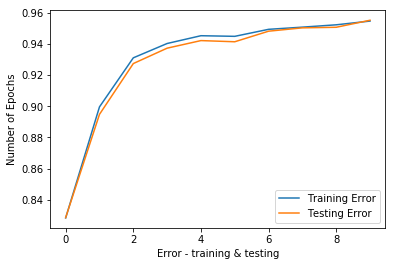

In [91]:
epochs = np.arange(num_epochs)

plt.plot(epochs, acc_train, label='Training Error')
plt.plot(epochs, acc_test, label='Testing Error')
plt.xlabel('Error - training & testing')
plt.ylabel('Number of Epochs')
plt.legend()

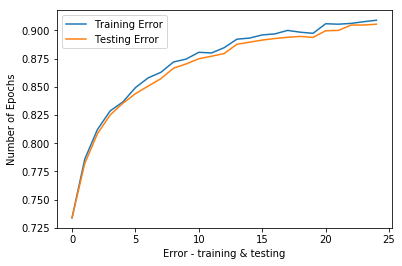

In [104]:
epochs = np.arange(num_epochs)

plt.plot(epochs, acc_train, label='Training Error')
plt.plot(epochs, acc_test, label='Testing Error')
plt.xlabel('Error - training & testing')
plt.ylabel('Number of Epochs')
plt.legend()

<b>Problem 5(b):</b> Write new code to perform *6-fold* cross validation on this model.
1.  Create a function called ```create_train_val_split()``` that will take a fold number and return an appropriate training set loader and validation set loader (```train_loader, val_loader```) .  It will be used in a loop that will loop over ```range(num_folds)``` to cross validate the model.  It should use contiguous sampling (use ```SequentialSampler```).  Test that it works as expected and show your code.
2.  Modify main to create the 6-fold validation loop.  In the loop, you will assign the training and validation loaders, train the model <b>from scratch</b>, and compute the average validation loss over all 6 folds.  You may use the ```epoch_loader()``` function supplied to compute the loss (E_in) on the various data splits.  Test that your code works as expected and show your code.
3.  Set the filter hyperparameter ```v = 1``` and report the average validation error (for all 6 folds) below.  Report the error after training for 10 epochs per fold.

In [0]:
# Your code for create_train_val_split()
def create_train_val_split(fold_num):
    ...
    return train_loader, val_loader

In [0]:
# Your main modified for cross validation
def main():
    global train_loader
    run_training()

In [0]:
if __name__=='__main__':
    main()

In [0]:
# Report your average validation error for all 6 folds here.

<b>Problem 5(c): </b> Now use cross validation to perform *model selection*.  Select the best integer value for hyperparameter ```v``` from ```v = [0, 1, 2, 3, 4].```   Select the value based on the one that results in the lowest total cross validation error after 10 epochs of training.
1.  What are the cross validation errors for these five values of ```v```?  What is the best value for ```v```?   What are the corresponding validation accuracies?
2.  Using your best ```v``` value, retrain the model on <b>all</b> training data and report the test error and accuracy.  Is the test error lower or higher than the validation error?  Is the test accuracy lower or higher.  Is this expected?  Explain your answer.

In [0]:
# Your cross validation errors for the five values of v and best v

In [0]:
# Your test error and accuracy

Copyright (c) 2019 Ted Willke